In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda
Loaded records: 54
Total windows: 12924
RR clamp range (0.5%..99.5%): [77.43, 100.72]


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 001 | D=0.7371 | G=641.7561 | MissMAE=0.3462 | dRRloss=0.3251
Epoch 002 | D=0.0041 | G=701.4159 | MissMAE=0.3447 | dRRloss=0.3238
Epoch 003 | D=0.0032 | G=699.9592 | MissMAE=0.3397 | dRRloss=0.3179
Epoch 004 | D=0.0020 | G=691.8497 | MissMAE=0.3003 | dRRloss=0.2788
Epoch 005 | D=0.0010 | G=668.6754 | MissMAE=0.1875 | dRRloss=0.1675
Epoch 006 | D=0.0020 | G=660.2553 | MissMAE=0.1474 | dRRloss=0.1283
Epoch 007 | D=0.0012 | G=657.7046 | MissMAE=0.1352 | dRRloss=0.1161
Epoch 008 | D=0.0010 | G=656.2816 | MissMAE=0.1290 | dRRloss=0.1106
Epoch 009 | D=0.0008 | G=655.4219 | MissMAE=0.1240 | dRRloss=0.1057
Epoch 010 | D=-0.0014 | G=654.7729 | MissMAE=0.1203 | dRRloss=0.1033
Epoch 011 | D=0.0013 | G=654.5586 | MissMAE=0.1192 | dRRloss=0.1021
Epoch 012 | D=0.0017 | G=653.9775 | MissMAE=0.1178 | dRRloss=0.1012
Epoch 013 | D=0.0022 | G=652.2731 | MissMAE=0.1169 | dRRloss=0.1006
Epoch 014 | D=0.0002 | G=652.9702 | MissMAE=0.1162 | dRRloss=0.1003
Epoch 015 | D=-0.0004 | G=652.5708 | MissMAE=0.

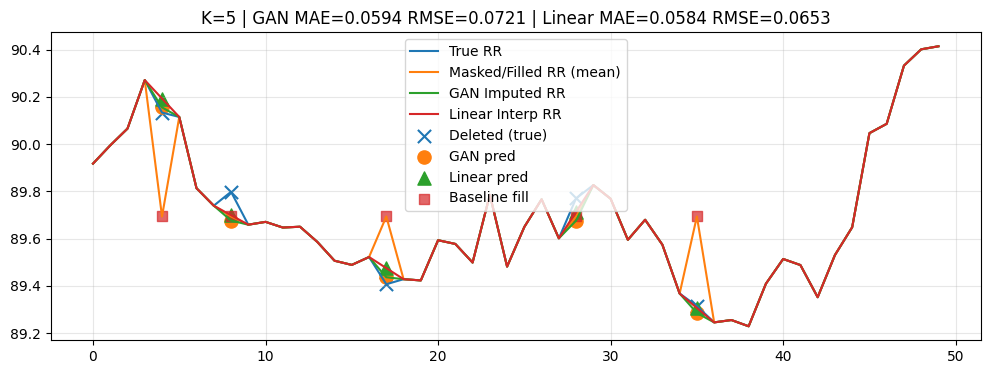

Saved: /kaggle/working/rr_imputer_lstm_wgangp_residual_linear_baseline.pt


In [2]:
# ============================================================
# Kaggle Notebook (FULL CODE - WITH LINEAR INTERPOLATION BASELINE)
# RR Interval Imputation with:
#   - LSTM Generator (predicts RESIDUAL over baseline fill)
#   - WGAN-GP Critic (1D CNN)
#   - Missing-only L1 loss (exact missing recovery)
#   - Physiology loss on dRR (prevents spikes)
#
# + DEBUG ADDITIONS:
#   ✅ Show which RR indices were deleted (mask)
#   ✅ Print TRUE deleted RR values
#   ✅ Print GAN PREDICTED RR values for those indices
#   ✅ Print LINEAR INTERPOLATION values for those indices (IEEE baseline)
#   ✅ Print BASELINE FILL (mean/ffill) values at missing indices
#   ✅ Print absolute errors
#   ✅ Plot: True, Baseline fill, GAN, Linear interpolation
# ============================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# CONFIG (edit as needed)
# -------------------------
DATASET_ROOT = "/kaggle/input/final-normal-sinus-dataset/normal-sinus-rhythm-rr-interval-database-1.0.0"
WINDOW_LEN   = 50
STRIDE       = 5
K_MISSING    = 5

BATCH_SIZE   = 128
EPOCHS       = 30
N_CRITIC     = 3

LR_G         = 2e-4
LR_D         = 2e-4

LAMBDA_MISS  = 200.0
LAMBDA_DRR   = 5.0
LAMBDA_SMOOTH= 0.02

GP_LAMBDA    = 10.0
FILL_MODE    = "mean"    # "mean" or "ffill"

SEED         = 42

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) LOAD YOUR RR RECORDS
# ============================================================
def load_rr_records(dataset_root: str):
    """
    Return: rr_records: List[np.ndarray], each shape (Li,), dtype float32
    Implement this based on your dataset format.

    If you already have rr_records from another cell (e.g., WFDB),
    you can skip this loader.
    """
    rr_records = []

    # ---- EXAMPLE: load from .npy files ----
    # for fn in sorted(os.listdir(dataset_root)):
    #     if fn.endswith(".npy"):
    #         arr = np.load(os.path.join(dataset_root, fn)).astype(np.float32)
    #         rr_records.append(arr)

    if len(rr_records) == 0:
        raise RuntimeError(
            "load_rr_records() returned 0 records.\n"
            "Edit load_rr_records() to match your dataset format."
        )
    return rr_records

# ============================================================
# IMPORTANT:
# If you already built rr_records using WFDB earlier, keep that and comment this.
# DUMMY fallback so the notebook runs end-to-end (REMOVE for real data).
# ============================================================
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)
    rr_records.append(base.astype(np.float32))
print("Loaded records:", len(rr_records))

# ============================================================
# 2) WINDOWING DATASET
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for rec in rr_records:
            rec = np.asarray(rec, dtype=np.float32)
            if len(rec) < window_len:
                continue
            for s in range(0, len(rec) - window_len + 1, stride):
                self.samples.append(rec[s:s+window_len])
        if len(self.samples) == 0:
            raise ValueError("No windows created. Reduce WINDOW_LEN/STRIDE or check data lengths.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# 3) MASKING / FEATURES
# ============================================================
def make_mask_and_corrupt(x, K=5, fill_mode="mean"):
    """
    Random missing indices (your original setup).
    """
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_missing_list = []

    for b in range(B):
        idx = torch.randperm(T, device=x.device)[:K]
        m[b, idx] = 0.0
        idx_missing_list.append(idx)

    if fill_mode == "mean":
        obs_sum = (x * m).sum(dim=1, keepdim=True)
        obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1.0)
        fill = obs_sum / obs_cnt
        x_obs = x * m + fill * (1.0 - m)

    elif fill_mode == "ffill":
        x_obs = x.clone()
        for b in range(B):
            missing = (m[b] == 0)
            obs_idx = torch.where(m[b] == 1)[0]
            if len(obs_idx) == 0:
                continue
            prev = x_obs[b, obs_idx[0]].item()
            for t in range(T):
                if missing[t]:
                    x_obs[b, t] = prev
                else:
                    prev = x_obs[b, t].item()
    else:
        raise ValueError("fill_mode must be 'mean' or 'ffill'")

    return x_obs, m, idx_missing_list

def drr(x):
    dx = x[:, 1:] - x[:, :-1]
    dx = torch.cat([torch.zeros((x.size(0), 1), device=x.device), dx], dim=1)
    return dx

# ============================================================
# 3b) LINEAR INTERPOLATION BASELINE (IEEE REQUIRED)
# ============================================================
def linear_interpolate_fill(x_true, idx_missing):
    """
    x_true: (T,) numpy array
    idx_missing: array of missing indices
    Returns x_lin: (T,) numpy array with missing values linearly interpolated
    """
    T = len(x_true)
    x_lin = x_true.copy().astype(np.float32)

    miss_idx = np.array(sorted(idx_missing), dtype=int)
    mask_obs = np.ones(T, dtype=bool)
    mask_obs[miss_idx] = False
    obs_idx = np.where(mask_obs)[0]

    if len(obs_idx) == 0:
        return x_lin

    # np.interp: linear interpolation; also extrapolates ends using nearest
    x_lin[miss_idx] = np.interp(miss_idx, obs_idx, x_true[obs_idx]).astype(np.float32)
    return x_lin

def mae_rmse_on_missing(x_pred, x_true, idx_missing):
    err = x_pred[idx_missing] - x_true[idx_missing]
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    return mae, rmse

# ============================================================
# 4) MODELS
# ============================================================
class LSTMGeneratorResidual(nn.Module):
    def __init__(self, hidden=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x_base, m, noise):
        dx = drr(x_base)
        inp = torch.stack([x_base, m, dx, noise], dim=-1)
        h, _ = self.lstm(inp)
        delta = self.head(h).squeeze(-1)
        return delta

class CNNWganCritic(nn.Module):
    def __init__(self, channels=64, kernel=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel, padding=kernel//2),
            nn.LeakyReLU(0.2),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h = self.net(x)
        h = self.pool(h).squeeze(-1)
        return self.fc(h).squeeze(-1)

# ============================================================
# 5) WGAN-GP gradient penalty
# ============================================================
def gradient_penalty(critic, real, fake, gp_lambda=10.0):
    B = real.size(0)
    eps = torch.rand(B, 1, device=real.device).expand_as(real)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)

    scores = critic(x_hat)
    grads = torch.autograd.grad(
        outputs=scores,
        inputs=x_hat,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean() * gp_lambda
    return gp

# ============================================================
# 6) TRAIN
# ============================================================
def train_wgan(rr_records):
    ds = RRWindowDataset(rr_records, window_len=WINDOW_LEN, stride=STRIDE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    print("Total windows:", len(ds))

    G = LSTMGeneratorResidual(hidden=64, num_layers=2, dropout=0.1).to(device)
    D = CNNWganCritic(channels=64, kernel=5).to(device)

    opt_g = optim.Adam(G.parameters(), lr=LR_G, betas=(0.5, 0.9))
    opt_d = optim.Adam(D.parameters(), lr=LR_D, betas=(0.5, 0.9))

    all_vals = np.concatenate([np.asarray(r, dtype=np.float32) for r in rr_records])
    lo, hi = np.percentile(all_vals, [0.5, 99.5]).astype(np.float32)
    lo, hi = float(lo), float(hi)
    print(f"RR clamp range (0.5%..99.5%): [{lo:.2f}, {hi:.2f}]")

    for ep in range(1, EPOCHS + 1):
        G.train(); D.train()
        d_sum = g_sum = miss_sum = drr_sum = 0.0

        for x in dl:
            x = x.to(device)

            # ---- Critic updates ----
            for _ in range(N_CRITIC):
                with torch.no_grad():
                    x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
                    noise = torch.rand_like(x) * (1.0 - m)
                    delta = G(x_base, m, noise)
                    x_hat = m * x + (1.0 - m) * (x_base + delta)
                    x_hat = torch.clamp(x_hat, lo, hi)

                real_score = D(x)
                fake_score = D(x_hat)
                gp = gradient_penalty(D, x, x_hat, gp_lambda=GP_LAMBDA)
                d_loss = (fake_score.mean() - real_score.mean()) + gp

                opt_d.zero_grad(set_to_none=True)
                d_loss.backward()
                opt_d.step()

            # ---- Generator update ----
            x_base, m, _ = make_mask_and_corrupt(x, K=K_MISSING, fill_mode=FILL_MODE)
            noise = torch.rand_like(x) * (1.0 - m)
            delta = G(x_base, m, noise)
            x_hat = m * x + (1.0 - m) * (x_base + delta)
            x_hat = torch.clamp(x_hat, lo, hi)

            adv = -D(x_hat).mean()

            denom = (1.0 - m).sum().clamp(min=1.0)
            miss_mae = (torch.abs(x_hat - x) * (1.0 - m)).sum() / denom

            m_pair = m[:, 1:] * m[:, :-1]
            miss_drr_mask = 1.0 - m_pair
            drr_hat = x_hat[:, 1:] - x_hat[:, :-1]
            drr_true = x[:, 1:] - x[:, :-1]
            denom_drr = miss_drr_mask.sum().clamp(min=1.0)
            drr_loss = (torch.abs(drr_hat - drr_true) * miss_drr_mask).sum() / denom_drr

            smooth = torch.mean(torch.abs(drr_hat))

            g_loss = adv + LAMBDA_MISS * miss_mae + LAMBDA_DRR * drr_loss + LAMBDA_SMOOTH * smooth

            opt_g.zero_grad(set_to_none=True)
            g_loss.backward()
            opt_g.step()

            d_sum += d_loss.item()
            g_sum += g_loss.item()
            miss_sum += miss_mae.item()
            drr_sum += drr_loss.item()

        print(
            f"Epoch {ep:03d} | D={d_sum/len(dl):.4f} | G={g_sum/len(dl):.4f} | "
            f"MissMAE={miss_sum/len(dl):.4f} | dRRloss={drr_sum/len(dl):.4f}"
        )

    return G, D, lo, hi

# ============================================================
# 7) INFERENCE + DEBUG PRINTS (GAN + LINEAR BASELINE)
# ============================================================
@torch.no_grad()
def impute_one_window(G, rr_window, lo=None, hi=None, K=5, verbose=True):
    """
    Returns:
      x_true, x_base(mean/ffill), x_gan, x_linear, idx_missing,
      gan_mae, gan_rmse, lin_mae, lin_rmse
    """
    G.eval()
    x = torch.tensor(rr_window, dtype=torch.float32, device=device).unsqueeze(0)  # (1,T)
    x_base, m, idx_list = make_mask_and_corrupt(x, K=K, fill_mode=FILL_MODE)
    idx_missing = idx_list[0].detach().cpu().numpy()

    noise = torch.rand_like(x) * (1.0 - m)
    delta = G(x_base, m, noise)
    x_hat = m * x + (1.0 - m) * (x_base + delta)

    if lo is not None and hi is not None:
        x_hat = torch.clamp(x_hat, lo, hi)

    x_true = x.squeeze(0).cpu().numpy()
    x_base_np = x_base.squeeze(0).cpu().numpy()
    x_gan = x_hat.squeeze(0).cpu().numpy()

    # Linear interpolation baseline uses TRUE observed points to fill missing
    x_lin = linear_interpolate_fill(x_true, idx_missing)

    gan_mae, gan_rmse = mae_rmse_on_missing(x_gan, x_true, idx_missing)
    lin_mae, lin_rmse = mae_rmse_on_missing(x_lin, x_true, idx_missing)

    if verbose:
        order = np.argsort(idx_missing)
        idx_s = idx_missing[order]

        print("\n================ Missing-value Debug ================")
        print(f"K={K} missing points")
        print("Deleted indices        :", idx_s.tolist())
        print("Deleted TRUE values    :", np.round(x_true[idx_s], 4).tolist())
        print("GAN predicted values   :", np.round(x_gan[idx_s], 4).tolist())
        print("Linear interp values   :", np.round(x_lin[idx_s], 4).tolist())
        print("Baseline(mean/ffill)   :", np.round(x_base_np[idx_s], 4).tolist())
        print(f"GAN    -> MAE={gan_mae:.6f} | RMSE={gan_rmse:.6f}")
        print(f"Linear -> MAE={lin_mae:.6f} | RMSE={lin_rmse:.6f}")
        print("=====================================================\n")

    return x_true, x_base_np, x_gan, x_lin, idx_missing, gan_mae, gan_rmse, lin_mae, lin_rmse

def plot_imputation(x_true, x_base, x_gan, x_lin, idx_missing, title="RR Imputation (GAN vs Linear)"):
    plt.figure(figsize=(12,4))
    plt.plot(x_true, label="True RR")
    plt.plot(x_base, label=f"Masked/Filled RR ({FILL_MODE})")
    plt.plot(x_gan, label="GAN Imputed RR")
    plt.plot(x_lin, label="Linear Interp RR")

    plt.scatter(idx_missing, x_true[idx_missing], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx_missing, x_gan[idx_missing], marker="o", s=90, label="GAN pred")
    plt.scatter(idx_missing, x_lin[idx_missing], marker="^", s=90, label="Linear pred")
    plt.scatter(idx_missing, x_base[idx_missing], marker="s", s=60, label="Baseline fill", alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# 8) RUN
# ============================================================
G, D, lo, hi = train_wgan(rr_records)

test_seq = rr_records[0][:WINDOW_LEN]

x_true, x_base, x_gan, x_lin, idx_missing, gan_mae, gan_rmse, lin_mae, lin_rmse = impute_one_window(
    G, test_seq, lo=lo, hi=hi, K=K_MISSING, verbose=True
)

plot_imputation(
    x_true, x_base, x_gan, x_lin, idx_missing,
    title=f"K={K_MISSING} | GAN MAE={gan_mae:.4f} RMSE={gan_rmse:.4f} | Linear MAE={lin_mae:.4f} RMSE={lin_rmse:.4f}"
)

# Save model
MODEL_PATH = "/kaggle/working/rr_imputer_lstm_wgangp_residual_linear_baseline.pt"
torch.save({
    "G_state": G.state_dict(),
    "lo": lo,
    "hi": hi,
    "window_len": WINDOW_LEN,
    "k_missing": K_MISSING
}, MODEL_PATH)
print("Saved:", MODEL_PATH)
